In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from matplotlib.colors import ListedColormap
from matplotlib import colors as mcolors
import math
import numpy as np
import matplotlib.pyplot as plt  # for plotting stuff
from random import seed
from scipy.stats import multivariate_normal  # generating synthetic data
from collections import namedtuple
from SVM import SVM
from DROFairModels import DROFairModels

In [5]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
from random import shuffle
h = .02  # step size in the mesh

def get_marginals(sensitives, target):
    """Calculate marginal probabilities of test data"""
    N_test = sensitives.shape[0]
    P_11 = np.sum(
        [1 / N_test if sensitives[i] == 1 and target[i] == 1 else 0 for i
         in range(N_test)])
    P_01 = np.sum(
        [1 / N_test if sensitives[i] == 0 and target[i] == 1 else 0 for i
         in range(N_test)])
    P_10 = np.sum(
        [1 / N_test if sensitives[i] == 1 and target[i] == 0 else 0 for i
         in range(N_test)])
    P_00 = np.sum(
        [1 / N_test if sensitives[i] == 0 and target[i] == 0 else 0 for i
         in range(N_test)])
    if np.abs(P_01 + P_10 + P_11 + P_00 - 1) > 1e-10:
        print(np.abs(P_01 + P_10 + P_11 + P_00 - 1))
        print('Marginals are WRONG!')
    return P_11, P_01, P_10, P_00

def stratified_sampling(X, a, y, emp_marginals, n_train_samples):
    emp_P_11 = emp_marginals[0]
    emp_P_01 = emp_marginals[1]
    emp_P_10 = emp_marginals[2]
    emp_P_00 = emp_marginals[3]
    X_11, X_01, X_10, X_00 = [], [], [], []
    for i in range(X.shape[0]):
        if a[i] == 1 and y[i] == 1:
            X_11.append(X[i, :])
        if a[i] == 0 and y[i] == 1:
            X_01.append(X[i, :])
        if a[i] == 1 and y[i] == 0:
            X_10.append(X[i, :])
        if a[i] == 0 and y[i] == 0:
            X_00.append(X[i, :])
    ind_11 = np.random.randint(low=0, high=np.array(X_11).shape[0], size=int(emp_P_11 * n_train_samples))
    ind_01 = np.random.randint(low=0, high=np.array(X_01).shape[0], size=int(emp_P_01 * n_train_samples))
    ind_10 = np.random.randint(low=0, high=np.array(X_10).shape[0], size=int(emp_P_10 * n_train_samples))
    ind_00 = np.random.randint(low=0, high=np.array(X_00).shape[0], size=int(emp_P_00 * n_train_samples))
    X_train_11 = np.array(X_11)[ind_11, :]
    X_train_01 = np.array(X_01)[ind_01, :]
    X_train_10 = np.array(X_10)[ind_10, :]
    X_train_00 = np.array(X_00)[ind_00, :]
    X_test11 = np.delete(np.array(X_11), ind_11, axis=0)
    X_test01 = np.delete(np.array(X_01), ind_01, axis=0)
    X_test10 = np.delete(np.array(X_10), ind_10, axis=0)
    X_test00 = np.delete(np.array(X_00), ind_00, axis=0)
    test_sensitives = np.hstack([[1] * X_test11.shape[0], [0] * X_test01.shape[0],
                                 [1] * X_test10.shape[0], [0] * X_test00.shape[0]])
    y_test = np.hstack([[1] * X_test11.shape[0], [1] * X_test01.shape[0],
                        [0] * X_test10.shape[0], [0] * X_test00.shape[0]])
    X_test = np.vstack([X_test11, X_test01, X_test10, X_test00])
    y_train = np.hstack([[1] * int(emp_P_11 * n_train_samples), [1] * int(emp_P_01 * n_train_samples),
                         [0] * int(emp_P_10 * n_train_samples), [0] * int(emp_P_00 * n_train_samples)])
    train_sensitives = np.hstack([[1] * int(emp_P_11 * n_train_samples), [0] * int(emp_P_01 * n_train_samples),
                                  [1] * int(emp_P_10 * n_train_samples), [0] * int(emp_P_00 * n_train_samples)])
    X_train = np.vstack([X_train_11, X_train_01, X_train_10, X_train_00])

    threshold = 1 - sum(y == 1) / y.shape[0]
    return X_train, train_sensitives, y_train, X_test, test_sensitives, y_test, threshold

def generate_synthetic_data_zafar(data_type,n_samples, plot_data=False):
    def gen_gaussian_diff_size(mean_in, cov_in, z_val, class_label, n):
        """
        mean_in: mean of the gaussian cluster
        cov_in: covariance matrix
        z_val: sensitive feature value
        class_label: +1 or -1
        n: number of points
        """

        nv = multivariate_normal(mean=mean_in, cov=cov_in)
        X = nv.rvs(n)
        y = np.ones(n, dtype=float) * class_label
        z = np.ones(n, dtype=float) * z_val  # all the points in this cluster get this value of the sensitive attribute

        return nv, X, y, z

    if data_type == 1:

        """
        Generate data such that a classifier optimizing for accuracy will have disparate false positive rates as well as disparate false negative rates for both groups.
        """

        cc = [[3.5, 0], [0, 3.5]]
        mu1, sigma1 = [6, 0], cc  # z=1, +
        cc = [[5, 0], [0, 5]]
        mu2, sigma2 = [-2, 0], cc  # z=0, +

        cc = [[3.5, 0], [0, 3.5]]
        mu3, sigma3 = [2, 0], cc  # z=1, -
        cc = [[5, 0], [0, 5]]
        mu4, sigma4 = [-4, 0], cc  # z=0, -

        nv1, X1, y1, z1 = gen_gaussian_diff_size(mu1, sigma1, 1, +1, int(n_samples * 5))  # z=1, +
        nv2, X2, y2, z2 = gen_gaussian_diff_size(mu2, sigma2, 0, +1, int(n_samples * 2))  # z=0, +
        nv3, X3, y3, z3 = gen_gaussian_diff_size(mu3, sigma3, 1, 0, int(n_samples * 5))  # z=1, -
        nv4, X4, y4, z4 = gen_gaussian_diff_size(mu4, sigma4, 0, 0, int(n_samples * 2))  # z=0, -


    # merge the clusters
    X = np.vstack((X1, X2, X3, X4))
    y = np.hstack((y1, y2, y3, y4))
    x_control = np.hstack((z1, z2, z3, z4))

    # shuffle the data
    perm = np.random.randint(0, X.shape[0], n_samples * 2)
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    x_control = x_control[perm]

    return X, y, x_control

In [6]:
SEED = 43
seed(SEED) 
np.random.seed(SEED)
rng = np.random.RandomState(2)
# LOAD DATASETS
a = None
y = None
test_set_fixed = 0
X, y, a = generate_synthetic_data_zafar(1, plot_data=True, n_samples=500)
# print(X)
# print(y)
# print(a)

true_P_11, true_P_01, true_P_10, true_P_00 = get_marginals(a, y)
emp_marginals = [true_P_11, true_P_01, true_P_10, true_P_00]
# Parameter GRID
radius = .045
eta = 0.123455 #min(true_P_01, true_P_11)-0.009

X_train, a_train, y_train, X_test, a_test, y_test, threshold = stratified_sampling(
            X=X,
            a=a,
            y=y, emp_marginals=emp_marginals,
            n_train_samples=27)


idx_list=[]
for idx in range(len(X_train)):
    for i in range(idx+1,len(X_train)):
        if np.array_equal(X_train[idx],X_train[i]):
            idx_list.append(i)
for idx in idx_list:   
    X_train,a_train,y_train=np.delete(X_train,idx,0),np.delete(a_train,idx,0),np.delete(y_train,idx,0)

In [7]:
for i in range(y_train.shape[0]):
    if y_train[i]==0:
        y_train[i]=-1
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        y_test[i]=-1

### STANDARD SVM
csvm = SVM(fit_intercept=True, verbose=True, reg=False)
csvm.fit(X=X_train, y=y_train)


### FAIR SVM
eta=1.35
fsvm=DROFairModels(reg=eta, radius=0, epsilon=0.0,
                                  verbose=False, fit_intercept=True, mode='DRFSVM')
fsvm.fit(X=X_train, a=a_train, y=y_train)


### DRO FAIR SVM
dfsvm=DROFairModels(reg=eta, radius=0.1, epsilon=0.0,
                                  verbose=False, fit_intercept=True, mode='DRFSVM')
dfsvm.fit(X=X_train, a=a_train, y=y_train)



# Prob
eta=0.1
sprob=DROFairModels(reg=1, radius=0, epsilon=0.01,
                                  verbose=False, fit_intercept=True, mode='DRFPROB')
sprob.fit(X=X_train, a=a_train, y=y_train)



# FPROB
fprob=DROFairModels(reg=eta, radius=0, epsilon=0.05,
                                  verbose=False, fit_intercept=True, mode='DRFPROB')
fprob.fit(X=X_train, a=a_train, y=y_train)


# DRO FAIR Prob
drfprob=DROFairModels(reg=eta, radius=0.2, epsilon=0.05,
                                  verbose=False, fit_intercept=True, mode='DRFPROB')
drfprob.fit(X=X_train, a=a_train, y=y_train)



Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-24


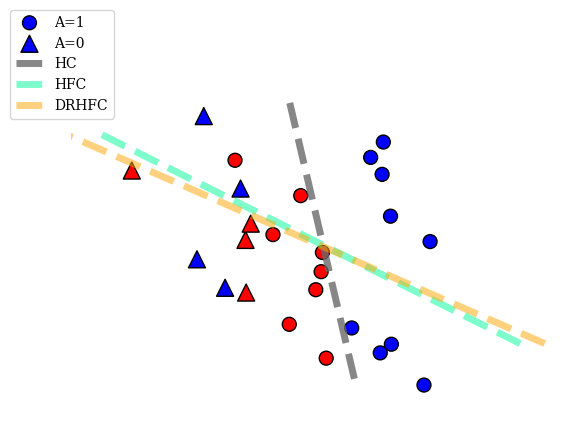

In [8]:
#Plot the graph
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


from matplotlib import rcParams

figure = plt.figure()
plt.axis('off')
y_plot_min = -4
y_plot_max = 4
y_plot_min1 = -3
y_plot_max1 = 3
x_plot_min = -2.5
x_plot_max = 2



from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
div = max(X_train[:, 0]) / 4 - min(X_train[:, 0]) / 4
plt.scatter(X_train[a_train == 1, 0], X_train[a_train == 1, 1], cmap=cm_bright, marker='o',
            edgecolors='k',
            c=(y_train[a_train == 1]), label='A=1', alpha=1, s=100)

plt.scatter(X_train[a_train == 0, 0], X_train[a_train == 0, 1], cmap=cm_bright, marker='^',
            edgecolors='k',
            c=y_train[a_train == 0], label='A=0', alpha=1, s=150)


rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
div = max(X_train[:, 0]) / 4 - min(X_train[:, 0])/4

boundary_csvm = -(np.linspace(y_plot_min, y_plot_max, 100) * csvm.coef_[1] + csvm.intercept_) / ( csvm.coef_[0])

boundary_fsvm = -(np.linspace(y_plot_min1, y_plot_max1, 100) * fsvm.coef_[1] + fsvm.intercept_) / ( fsvm.coef_[0])

boundary_dfsvm = -(np.linspace(y_plot_min1, y_plot_max1, 100) * dfsvm.coef_[1] + dfsvm.intercept_) / ( dfsvm.coef_[0])

boundary_sprob = -(np.linspace(y_plot_min, y_plot_max, 100) * sprob.coef_[1] + sprob.intercept_) / ( sprob.coef_[0])

boundary_fprob = -(np.linspace(y_plot_min, y_plot_max, 100) * fprob.coef_[1] + fprob.intercept_) / ( fprob.coef_[0])

boundary_drfprob = -(np.linspace(y_plot_min, y_plot_max, 100) * drfprob.coef_[1] + drfprob.intercept_) / ( drfprob.coef_[0])





plt.plot(boundary_csvm, np.linspace(y_plot_min, y_plot_max, 100), linestyle='dashed', label='HC',
         c=colors['dimgrey'], linewidth=5, alpha=0.8)

plt.plot(boundary_fsvm, np.linspace(y_plot_min1, y_plot_max1, 100), linestyle='dashed', label='HFC',
         c=colors['mediumspringgreen'], linewidth=5, alpha=0.5)
plt.plot(boundary_dfsvm, np.linspace(y_plot_min1, y_plot_max1, 100), linestyle='dashed', label='DRHFC',
         c=colors['orange'], linewidth=5, alpha=0.5)


plt.legend()
plt.legend(bbox_to_anchor=(0.10, 0.78))
plt.xlim(-10,15) 
plt.ylim(-5,5.5) 
left, right = plt.ylim() 

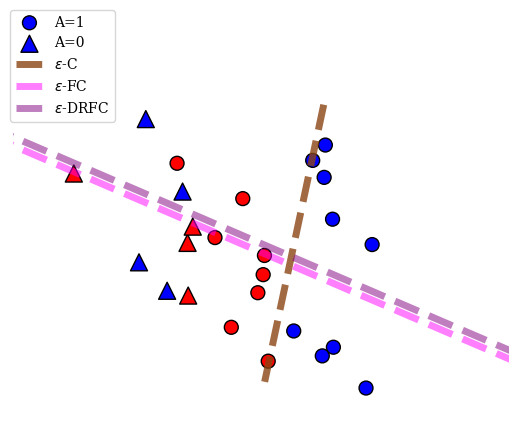

In [14]:

figure = plt.figure()
plt.axis('off')
y_plot_min = -4
y_plot_max = 4
y_plot_min1 = -3
y_plot_max1 = 3
x_plot_min = -2.5
x_plot_max = 2
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
div = max(X_train[:, 0]) / 4 - min(X_train[:, 0]) / 4
plt.scatter(X_train[a_train == 1, 0], X_train[a_train == 1, 1], cmap=cm_bright, marker='o',
            edgecolors='k',
            c=(y_train[a_train == 1]), label='A=1', alpha=1, s=100)

plt.scatter(X_train[a_train == 0, 0], X_train[a_train == 0, 1], cmap=cm_bright, marker='^',
            edgecolors='k',
            c=y_train[a_train == 0], label='A=0', alpha=1, s=150)
plt.plot(boundary_sprob, np.linspace(y_plot_min, y_plot_max, 100), linestyle='dashed', label='$\epsilon$-C',
         c=colors['saddlebrown'], linewidth=5, alpha=0.8)

plt.plot(boundary_fprob, np.linspace(y_plot_min, y_plot_max, 100), linestyle='dashed', label='$\epsilon$-FC',
         c=colors['magenta'], linewidth=5, alpha=0.5)

plt.plot(boundary_drfprob, np.linspace(y_plot_min, y_plot_max, 100), linestyle='dashed', label='$\epsilon$-DRFC',
         c=colors['purple'], linewidth=5, alpha=0.5)

plt.legend()
plt.legend(bbox_to_anchor=(0.10, 0.78))
plt.xlim(-10,15) 
plt.ylim(-5,5.5) 
left, right = plt.ylim() 